In [1]:
using LinearAlgebra
using Statistics
using Plots
using LaTeXStrings
using Peaks

In [2]:
include("ED_functions_spinless_fermions.jl")

fermi_dirac_distribution (generic function with 1 method)

In [7]:
function Build_H(N, Δ, μ, E, J = 1.0)
    #J: Hopping amplitude.
    #Δ: Nearest-neighbor density-density interaction.
    #μ: Chemical potential of the diode.
    #E: Tilt strength.

    H = zeros(2^N, 2^N)
    
    for i=1:N-1 #H_S
        H += 0.5*J*Build_C_dagi_Cj_Matrix(N, i, i+1)
        H += 0.5*J*Build_C_dagi_Cj_Matrix(N, i+1, i)
        # H += Δ*(Build_C_dagi_Cj_Matrix(N, i, i)-0.5*Enlarge_Matrix_site_j(N, 1, Identity))*(Build_C_dagi_Cj_Matrix(N, i+1, i+1)-0.5*Enlarge_Matrix_site_j(N, 1, Identity))
        H += Δ*Build_C_dagi_Cj_Matrix(N, i, i)*Build_C_dagi_Cj_Matrix(N, i+1, i+1) #Interaction 2 (the one used in the mesoscopic method) They results in different behavior if I do not shift the energies as is commented in the next for.
    end

    for i=1:N
        H += (μ + 0.5*E*i)*(Build_C_dagi_Cj_Matrix(N, i, i)-0.5*Enlarge_Matrix_site_j(N, 1, Identity))
        i==1 || i==N ? H+= -0.5*Δ*Build_C_dagi_Cj_Matrix(N, i, i) : H+= -Δ*Build_C_dagi_Cj_Matrix(N, i, i) #This is what I should add in the energies if I want to reproduce their results using the mesoscopic method.
    end
        
    return H
end

function Build_JP_persite_operators(N, J = 1.0)
    #J: Hopping amplitude.
    
    JP_operators = []
    for i=1:N-1
        JP_i = 1im*J*0.5*(Build_C_dagi_Cj_Matrix(N, i, i+1) - Build_C_dagi_Cj_Matrix(N, i+1, i)) #J_i = i(J/2)*(c†i*ci+1 - c†i+1*ci)
        push!(JP_operators, JP_i)
    end

    return JP_operators
end

function Build_Liouvillian_Superoperator(H, gamma_k_list, L_k_list)

    N = log2(size(H)[1])
    superIdentity = Enlarge_Matrix_site_j(N, 1, Identity)
    
    superH = -1im*(kron(superIdentity, H) - kron(transpose(H), superIdentity))
    superL = zeros(size(superH))
    
    for k=1:length(gamma_k_list)
        L_k = L_k_list[k]
        gamma_k = gamma_k_list[k]
        superL = superL + gamma_k*(kron(conj(L_k), L_k) -0.5*(kron(superIdentity, adjoint(L_k)*L_k) + kron(transpose(L_k)*conj(L_k), superIdentity)))
    end

    Liouvillian_Superoperator = superH + superL
    return Liouvillian_Superoperator
end

Build_Liouvillian_Superoperator (generic function with 1 method)

In [8]:
N = 4
Δ = 5.0

Γ = 1.0
f_values = [-1.0, 1.0] #f>0 forward (L -> R), f<0 reverse (L <- R). 

#Operators does not change for all cases
JP_operators = Build_JP_persite_operators(N);  #Current operators in each site, it just depend on J and N

L_1_plus = Build_Cdag_Matrix(N, 1)
L_1_minus = Build_C_Matrix(N, 1)
L_N_plus = Build_Cdag_Matrix(N, N)
L_N_minus = Build_C_Matrix(N, N) 

L_k_list = Matrix{ComplexF64}[L_1_plus, L_1_minus, L_N_plus, L_N_minus];

In [9]:
E_values = LinRange(0, 12, 100)
JP_dict = Dict()

for f =  f_values
    gamma_k_list = [Γ*(1+f)/8, Γ*(1-f)/8, Γ*(1-f)/8, Γ*(1+f)/8]    

    JP_dict[f] = []

    for E = E_values
        μ = -E*(N+1)/4

        H = Build_H(N, Δ, μ, E);
        Liouvillian_Superoperator = Build_Liouvillian_Superoperator(H, gamma_k_list, L_k_list)        

        GS = nullspace(Liouvillian_Superoperator)
        rho_ss = reshape(GS, size(H)) #Steady State
        rho_ss = rho_ss./tr(rho_ss)
        
        J0 = 2*Γ*f/(Γ^2 +16) #Equation A(15 from article). 
        JP_i = [real(tr(JP_OP*rho_ss)) for JP_OP = JP_operators] 
        JP = mean(JP_i)/J0 #This already include the absolute value because J0 has the same sign of JP_i

        append!(JP_dict[f], JP)
    end
    
end

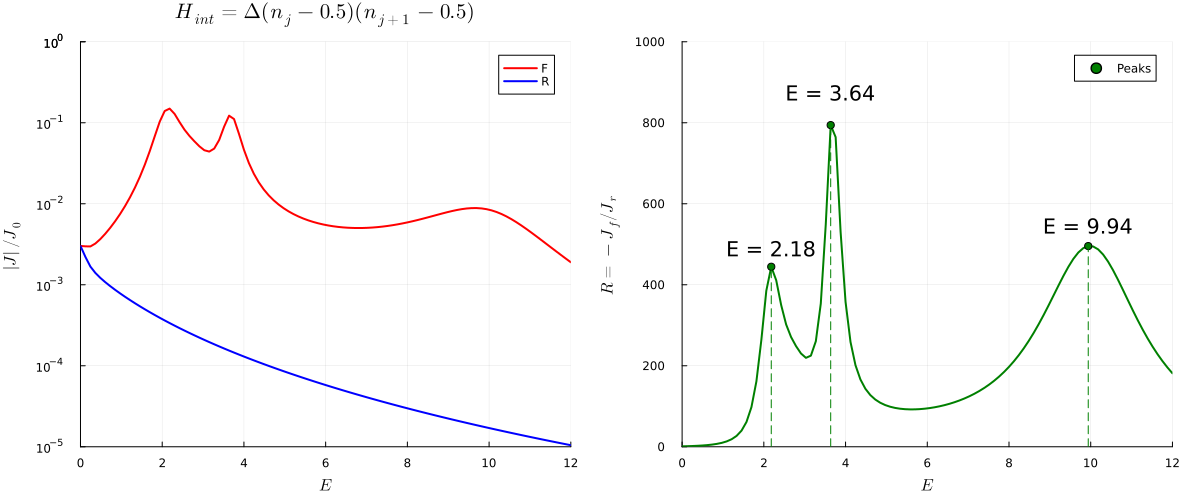

In [10]:
p1 = plot(E_values, JP_dict[1.0], label = "F", color = "red", linewidth = 2.0)
p1 = plot!(E_values, JP_dict[-1.0], label = "R", color = "blue", linewidth = 2.0)
p1 = plot!(yscale=:log10, yticks=[10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1], ylims = (10e-6, 1), xlims = (0.0, 12.0), ylabel = L"|J|/ J_{0}", xlabel = L"E")

title!(L"H_{int} = \Delta (n_{j} -0.5)(n_{j+1} -0.5)")
# title!(L"H_{int} = \Delta n_{j}n_{j+1}")

R = JP_dict[1.0]./JP_dict[-1.0]
indices, heights = findmaxima(R) #From Peaks.jl

p2 = plot(E_values, R, label = false, color = "green", linewidth = 2.0)
p2 = plot!(ylims = (0, 1000), xlims = (0.0, 12.0), ylabel = L"R = -J_{f}/J_{r}", xlabel = L"E")
p2 = scatter!([E_values[i] for i=indices ], heights, color = "green", label = "Peaks")

p2 = plot!([E_values[indices[1]], E_values[indices[1]]], [0, heights[1]], linestyle = :dash, color = "green", label = false)
p2 = plot!([E_values[indices[2]], E_values[indices[2]]], [0, heights[2]], linestyle = :dash, color = "green", label = false)
p2 = plot!([E_values[indices[3]], E_values[indices[3]]], [0, heights[3]], linestyle = :dash, color = "green", label = false)
p2 = annotate!([E_values[i] for i=indices ], heights*1.1, ["E = $(round(E_values[i]; digits = 2))" for i=indices ])

plot(p1,p2; size = (1200, 500), margin=5Plots.mm)

# savefig("ED Results (Interaction 1).pdf")

In [126]:
function Build_N(N)

    N_op = zeros(2^N, 2^N)
    for i=1:N
        N_op += Build_C_dagi_Cj_Matrix(N, i, i)
    end
        
    return N_op
end

Build_N (generic function with 1 method)

In [127]:
E_values = LinRange(0, 12, 200)

eigenvalues = Dict()

N_op = Build_N(N)
for E = E_values
    μ = -E*(N+1)/4
    H = Build_H(N, Δ, μ, E)
    
    eigenvals = []
    for i = 1:2^N
        ψ = eigen(H).vectors[:, i]
        particle_number = adjoint(ψ)*N_op*ψ
        eigenval = real(adjoint(ψ)*H*ψ)
        isapprox(particle_number, 2.0) ? append!(eigenvals, eigenval) : nothing
    end

    eigenvalues[E] = eigenvals #Just eigenvalues with n = 2.
    # eigenvalues[E] = eigen(H).values #All eigenvalues
    
end

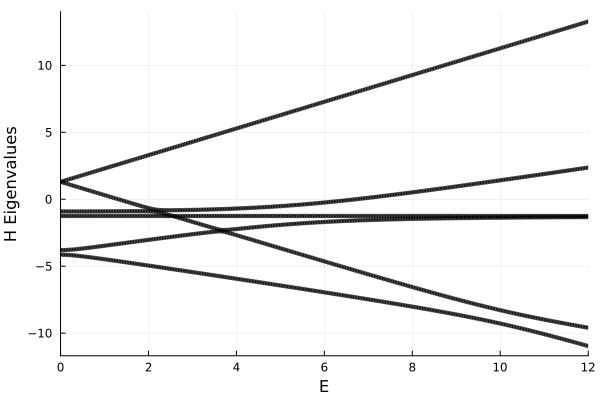

In [25]:
scatter()

for E = E_values
scatter!(eigenvalues[E].*0 .+E, eigenvalues[E], label = false, markersize = 2.5, color = "black", alpha = 0.7)
end

ylabel!("H Eigenvalues")
xlabel!("E")
xlims!(0, 12.0)

In [26]:
eigenvalues[0.0]

6-element Vector{Any}:
 -4.142129814497759
 -3.7995097567963927
 -1.25
 -0.9114949566275019
  1.2995097567963925
  1.3036247711252609

In [28]:
real(N_op)

16×16 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  2.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  3.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  